In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt
import h5py
import wandb
import random


# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)



2024-04-04 14:52:43.604835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16424 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [9]:
import wandb
import tensorflow as tf
import numpy as np
import h5py
from tensorflow.keras import layers, models, optimizers



with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)


In [13]:
images.shape

(10000, 64, 64)

In [18]:


image_normalized = (images + 1e-9) / 9.26
normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized

probabilities = np.array(normalized_boxes[:, :, :-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)




# total_items = 10000
# train_size = int(total_items * 0.8)
# val_size = total_items - train_size

# # Splitting the dataset
# train_dataset = dataset.take(train_size)
# val_dataset = dataset.take(val_size)


# train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(batch_size)
# val_dataset = val_dataset.batch(batch_size) 

    
    
    
   

In [19]:
 
    

    
input_shape = (64,64,1)
num_classes = 280
num_coordinates = 4

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 11
        
#         # Fit the model with both training and validation datasets
# model.fit(train_dataset, 
#                   epochs=num_epochs, 
#                   validation_data=val_dataset, 
#                   )

        # Fit the model with both training and validation datasets
model.fit(dataset, 
                  epochs=num_epochs
                  
                  )

Epoch 1/11


2024-04-04 14:55:18.362930: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-04 14:55:18.449672: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 14:55:19.450556: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 14:55:20.466312: I external/local_xla/xla/service/service.cc:168] XLA service 0x5c1b50481ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 14:55:20.466336: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-04 14:55:20.471072: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712256920.590157  915296 device_compiler.

79/79 [==============================] - 21s 95ms/step - loss: 0.5227 - x_prob_reshape_loss: 0.3880 - x_boxes_reshape_loss: 0.1347 - x_prob_reshape_accuracy: 0.8405
Epoch 2/11
79/79 [==============================] - 6s 73ms/step - loss: 0.2454 - x_prob_reshape_loss: 0.1777 - x_boxes_reshape_loss: 0.0677 - x_prob_reshape_accuracy: 0.9516
Epoch 3/11
79/79 [==============================] - 6s 72ms/step - loss: 0.1958 - x_prob_reshape_loss: 0.1409 - x_boxes_reshape_loss: 0.0548 - x_prob_reshape_accuracy: 0.9547
Epoch 4/11
79/79 [==============================] - 6s 73ms/step - loss: 0.1718 - x_prob_reshape_loss: 0.1212 - x_boxes_reshape_loss: 0.0506 - x_prob_reshape_accuracy: 0.9584
Epoch 5/11
79/79 [==============================] - 6s 72ms/step - loss: 0.1543 - x_prob_reshape_loss: 0.1060 - x_boxes_reshape_loss: 0.0483 - x_prob_reshape_accuracy: 0.9635
Epoch 6/11
79/79 [==============================] - 6s 71ms/step - loss: 0.1456 - x_prob_reshape_loss: 0.0985 - x_boxes_reshape_loss: 0

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

# # Assuming dataset has 10,000 examples and we want an 80/20 split
# total_items = 10000
# train_size = int(total_items * 0.6)
# # val_size = total_items - train_size

# # Splitting the dataset
# train_dataset = dataset.take(train_size)
# # val_dataset = dataset.skip(train_size)


# # train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(6000)
# inputs,targets = next(iter(train_dataset))
dataset = dataset.batch(10000)
inputs,targets = next(iter(dataset))
output = model.predict(inputs)

313/313 [==============================] - 3s 8ms/step


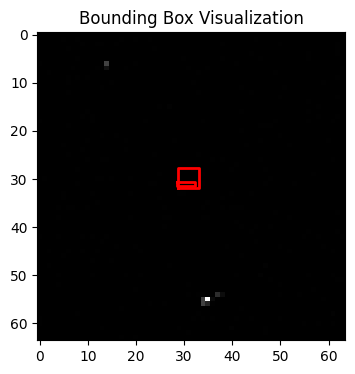

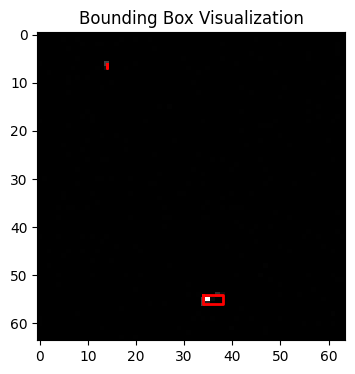

In [30]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,400)


visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction





In [7]:
import matplotlib.pyplot as plt

def visualize_comparisons(image, true_probs, true_boxes, pred_probs, pred_boxes, threshold=0.9):
    """
    Visualizes true and predicted bounding boxes on an image.

    Parameters:
    - image: The image to visualize.
    - true_probs: True probabilities for each bounding box.
    - true_boxes: True bounding box coordinates.
    - pred_probs: Predicted probabilities for each bounding box.
    - pred_boxes: Predicted bounding box coordinates.
    - threshold: Probability threshold for showing bounding boxes.
    """
    # Assuming image normalization that can be directly visualized
    plt.imshow(image.squeeze(), cmap='gray')  # Adjust if your image has more than one channel
    plt.title("True vs. Predicted Bounding Boxes")

    # Iterate over true boxes
    for i, prob in enumerate(true_probs):
        if prob > threshold:
            bbox = true_boxes[i]
            plt.plot([bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]],
                     [bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]],
                     color='green', linewidth=2, label='True Box' if i == 0 else "")

    # Iterate over predicted boxes
    for i, prob in enumerate(pred_probs):
        if prob > threshold:
            bbox = pred_boxes[i]
            plt.plot([bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]],
                     [bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]],
                     color='red', linewidth=2, linestyle='dashed', label='Predicted Box' if i == 0 else "")

    plt.legend()
    plt.show()


# Assuming `val_dataset` is already defined and batched
for images, labels in val_dataset.take(1):  # Take 1 batch
    # Predict on the batch
    pred_probs, pred_boxes = model.predict(images)

    # Convert predictions and labels to the required format if necessary
    # This step depends on your data and model output format

    # Visualize the first image in the batch as an example
    image = images[0].numpy()  # Assuming TensorFlow dataset
    true_probs = labels['x_prob_reshape'][0].numpy().squeeze()
    true_boxes = labels['x_boxes_reshape'][0].numpy().squeeze() * [64,64,64,64]  # Rescale if your boxes were normalized
    pred_probs = pred_probs[0].squeeze()
    pred_boxes = pred_boxes[0].squeeze() * [64,64,64,64]  # Adjust scaling to match your data preparation

    visualize_comparisons(image, true_probs, true_boxes, pred_probs, pred_boxes)


NameError: name 'val_dataset' is not defined